# L2 – Multilayer perceptron

### PyTorch
1. [Installing PyTorch](https://pytorch.org/get-started/locally/)
2. [What is PyTorch?](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py)
3. [Autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)
4. [Useful examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)
5. [Mnist example](https://habr.com/company/otus/blog/358096/)


### One more thing
1. [Jupyter tutorial](https://habrahabr.ru/company/wunderfund/blog/316826/)
2. [Plot.ly](https://plot.ly/python/)
3. [Widgets](http://jupyter.org/widgets.html)

### 1. Linear multi-classification problem

We have already learned binary linear classifier
$$y = \text{sign}(w^Tx).$$
There are [several approaches](https://en.wikipedia.org/wiki/Multiclass_classification) to solve the problem of multi-class classification. For example [reduction](https://en.wikipedia.org/wiki/Multiclass_classification#Transformation_to_Binary) of problem to binary classifier or [modification](https://en.wikipedia.org/wiki/Support_vector_machine#Multiclass_SVM) of the known model. However we are interested in approaches that is applied in neural networks.

For each class $c \in 1, \dots, |C|$ we have an individual row $w_i$ of matrix $W$. Then the probability of $x$ belonging to a particular class is equal to
$$p_i = \frac{\exp(w^T_ix)}{\sum_j \exp(w^T_jx)}.$$
This is nothing, but [softmax](https://en.wikipedia.org/wiki/Softmax_function) function of $Wx$.
$$(p_1, \dots, p_{|C|}) = \text{softmax}(Wx).$$

If you look closely, $\text{softmax}$ is a more general variant of sigmoid. To see this, it suffices to consider the case $|C|=2$. As usual the training can be reduced to minimization of the empirical risk, namely, optimization problem
$$\arg\min_W Q(W) = \arg\min_W -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln(p_i(W)).$$
Actually, the maximization of the log-likelihood is written above.

#### Exercises
1. Find $\frac{dQ}{dW}$ in matrix form (hint: start with $\frac{dQ}{dw_i}$ for begining).
2. Please plot several mnist images (e.g using grid 5x5).
3. Train linear multi-label classifier for [mnist](https://www.kaggle.com/c/digit-recognizer) dataset (possible, [this tutorial](https://habr.com/company/otus/blog/358096/) can help you).
4. Chek accuracy on train and validation sets (visualize resulted graph).

In [205]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision.datasets
import torchvision.transforms as transforms

def make_data_mnist(path):
    train = pd.read_csv(path).values
    Y = np.zeros((1, train.shape[0]))
    for i in range(train.shape[0]):
        Y[0][i] = train[i][0]
        train[i][0] = 1
    train = train[:, 1:]
    return train, Y

def print_mnist(train_x, amount):
    for pos in range(amount):
        cur_digit = train_x[pos].reshape([28, 28])
        plt.imshow(cur_digit, cmap='gray')
        plt.show()

In [206]:
path = '/Users/diana/Documents/Project/mnist_data/train.csv'
train_x, train_y = make_data_mnist(path)

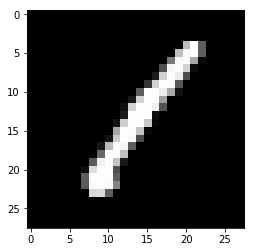

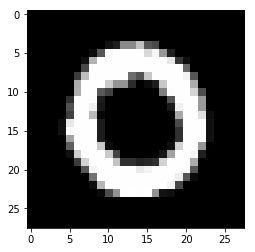

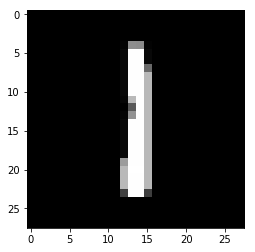

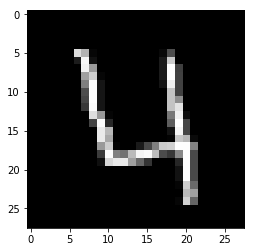

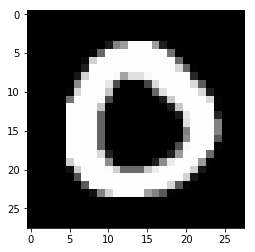

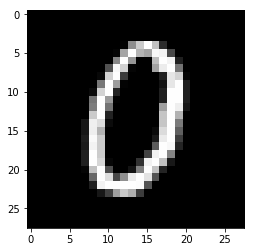

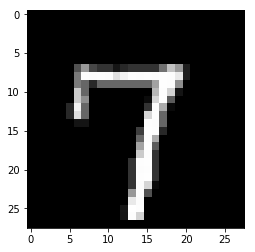

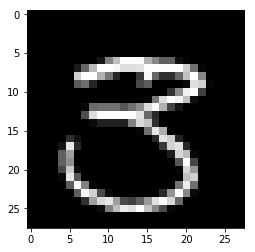

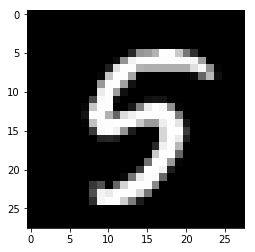

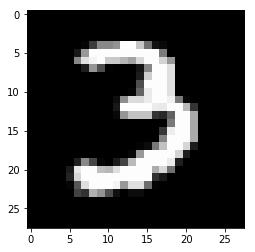

In [207]:
print_mnist(train_x, 10)

In [204]:
batch_size = 10
all_train = torchvision.datasets.MNIST("/Users/diana/Documents/Project", train=True, transform=transforms.ToTensor(), download=True)
test = torchvision.datasets.MNIST("/Users/diana/Documents/Project", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(all_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

Processing...
Done!


In [330]:
print(type(all_train))

<class 'torchvision.datasets.mnist.MNIST'>


In [291]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.softmax(x, dim=1)
        return x

In [292]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_accuracy_epoch = []
test_accuracy_epoch = []

In [293]:
def plot_accuracy(train_accuracy_epoch, test_accuracy_epoch, func):
    plt.plot(range(1, epoch_num), train_accuracy_epoch, color = "OrangeRed")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title(func + ', train')
    plt.show()

    plt.plot(range(1, epoch_num), test_accuracy_epoch, color = "PeachPuff")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title(func + ', test')
    plt.show()

In [326]:
def train(epoch, model=model):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
#     else:
#         print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#             epoch, batch_idx * len(data), len(train_loader.dataset),
#             100. * batch_idx / len(train_loader), loss.data.item()))

In [327]:
def test(log=None, model=model):
    with torch.no_grad():
        test_loss = 0
        test_correct = 0
        for data, target in test_loader:
            data, target = Variable(data), Variable(target)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).data.item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            test_correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_correct_percent = 100. * test_correct / len(test_loader.dataset)
        test_accuracy_epoch.append(test_correct_percent)

        train_loss = 0
        train_correct = 0
        for data, target in train_loader:
            data, target = Variable(data), Variable(target)
            output = model(data)
            train_loss += F.cross_entropy(output, target, size_average=False).data.item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            train_correct += pred.eq(target.data.view_as(pred)).sum()
        train_loss /= len(train_loader.dataset)
        train_correct_percent = 100. * train_correct / len(train_loader.dataset)
        train_accuracy_epoch.append(train_correct_percent)
        
    print('\nTest set:  Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, test_correct, len(test_loader.dataset), test_correct_percent))
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss, train_correct, len(train_loader.dataset), train_correct_percent))

In [328]:
epoch_num = 10
for epoch in range(1, epoch_num):
    train(epoch, model)
    test(' ', model)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.511548
Train Epoch: 1 [2000/60000 (3%)]	Loss: 1.471842
Train Epoch: 1 [4000/60000 (7%)]	Loss: 1.582781
Train Epoch: 1 [6000/60000 (10%)]	Loss: 1.585263
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.732678
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.525747
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.503028
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.492402
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.466644
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.498785
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.566406
Train Epoch: 1 [22000/60000 (37%)]	Loss: 1.542876
Train Epoch: 1 [24000/60000 (40%)]	Loss: 1.507552
Train Epoch: 1 [26000/60000 (43%)]	Loss: 1.591405
Train Epoch: 1 [28000/60000 (47%)]	Loss: 1.465744
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.478243
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.668254
Train Epoch: 1 [34000/60000 (57%)]	Loss: 1.571668
Train Epoch: 1 [36000/60000 (60%)]	Loss: 1.562992
Train Epoch: 1 [38000/60000 (63%)]	Loss: 1.591592
Train Epoch

Train Epoch: 6 [8000/60000 (13%)]	Loss: 1.498976
Train Epoch: 6 [10000/60000 (17%)]	Loss: 1.527474
Train Epoch: 6 [12000/60000 (20%)]	Loss: 1.476014
Train Epoch: 6 [14000/60000 (23%)]	Loss: 1.517255
Train Epoch: 6 [16000/60000 (27%)]	Loss: 1.605155
Train Epoch: 6 [18000/60000 (30%)]	Loss: 1.464543
Train Epoch: 6 [20000/60000 (33%)]	Loss: 1.646457
Train Epoch: 6 [22000/60000 (37%)]	Loss: 1.491595
Train Epoch: 6 [24000/60000 (40%)]	Loss: 1.644341
Train Epoch: 6 [26000/60000 (43%)]	Loss: 1.590994
Train Epoch: 6 [28000/60000 (47%)]	Loss: 1.512103
Train Epoch: 6 [30000/60000 (50%)]	Loss: 1.563348
Train Epoch: 6 [32000/60000 (53%)]	Loss: 1.560627
Train Epoch: 6 [34000/60000 (57%)]	Loss: 1.649018
Train Epoch: 6 [36000/60000 (60%)]	Loss: 1.558814
Train Epoch: 6 [38000/60000 (63%)]	Loss: 1.642432
Train Epoch: 6 [40000/60000 (67%)]	Loss: 1.566354
Train Epoch: 6 [42000/60000 (70%)]	Loss: 1.500561
Train Epoch: 6 [44000/60000 (73%)]	Loss: 1.539393
Train Epoch: 6 [46000/60000 (77%)]	Loss: 1.472224
T

In [ ]:
plot_accuracy(train_accuracy_epoch, test_accuracy_epoch, 'linear')

Let's briefly touch on themes of regularization. As was discussed before, there are different approaches. We focus on the modification of loss function.

$$\arg\min_W -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln(p_i(W)) + \lambda_1 L_1(W) + \lambda_2 L_2(W)$$

1. $L_1(W) = sum_{i,j} |w_{i,j}|$ - sparsify weights (force to not use uncorrelated features)
2. $L_2(W) = sum_{i,j} w_{i,j}^2$ - minimize weights (force to not overfit)

#### Exercises
1. Train model again using both type of regularization.
2. Plot matrix of weights.
3. Which pixels have zero weights? What does it mean?
4. Have you improved accuracy on validation?

### 2. Universal approximation theorem

What if we add more layers to our model? Namely, we train two matrix $W_2$ and $W_1$
$$softmax(W_2\cdot(W_1x)).$$

At first glance adding more parameters helps to increase the generalizing ability of the model. Buy actually we have the same model $softmax(Wx)$, where $W = W_2\cdot W_1$. But everyting changes with adding ome more layer. Let's add nonlinear function $\sigma$ between $W_2$ and $W_1$

$$softmax(W_2\cdot \sigma(W_1x)).$$

Kurt Hornik showed in 1991 that it is not the specific choice of the nonlinear function, but rather the multilayer feedforward architecture itself which gives neural networks the potential of being universal approximators. The output units are always assumed to be linear. For notational convenience, only the single output case will be shown. The general case can easily be deduced from the single output case.

Let $\sigma(\cdot)$ be a nonconstant, bounded, and monotonically-increasing continuous function.
Let $\mathcal{S}_m \subset \mathbb{R}^m$ denote any compact set. 
Then, given any $\varepsilon > 0$ and any coninuous function $f$ on $\mathcal{S}_m$, there exist an integer $N$ and real constants $v_i$, $b_i$ amd real vectors $w_i$ that

$$\left| \sum _{i=1}^{N}v_{i}\sigma \left( w_i^{T} x+b_i \right) - f(x) \right| < \varepsilon, ~~~ \forall x \in \mathcal{S}_m.$$

The theorem has non-constructive proof, it meams that no estimates for $N$ and no method to find approximation's parameters.

#### Exercises
1. Let $\sigma$ – [heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function) and $x \in \{0, 1\}^2$. Prove that $y = \sigma(wx + b)$ can approximate boolean function **OR** (hint: use constructive proof).
2. What about **AND** function?
3. Is it possible to implement **XOR**? Prove your words.
4. Prove that 2-layer network can implement any boolean function.

#### More useful facts:
1. A 2-layer network in in $\mathbb{R}^n$ allows to define convex polyhedron..
2. A 3-layer network in в $\mathbb{R}^n$ allows to define a not necessarily convex and not even necessarily connected area.

### 3. Backpropagation
Backpropagation is a method used to calculate the error contribution of each layer after a batch of data. It is a special case of an older and more general technique called automatic differentiation. In the context of learning, backpropagation is commonly used by the gradient descent optimization algorithm to adjust the weight of layers by calculating the gradient of the loss function. This technique is also sometimes called backward propagation of errors, because the error is calculated at the output and distributed back through the network layers. The main motivation of method is simplify evaluation of gradient which is complex problem for multilayer nets.

We need the following notation. Let $(y^1,\dots,y^n) = f(x^1,\dots,x^n)$ is some differentiable function and $\frac{dy}{dx}$ is matrix
$$\frac{dy}{dx} = \Big[ J_{ij} = \frac{\partial y^i}{\partial x^j} \Big]$$

Without violating the generality, we can assume that each layer is a function $x_{i} = f(x_{i-1}, w_i)$. As last layer we add loss function, so we can assume our multi-layer net as function $Q(x_0) = Q(f_n(f_{n-1}(\dots, w_{n-1}), w_n))$.

#### Forward step
Propagation forward through the network to generate the output values. Calculation of the loss function.

#### Backward step
Let's look at last layer. We can simply find $\frac{dQ}{dx_n}$. Now we can evaluate 

$$\frac{dQ}{dw_n} = \frac{dQ}{dx_n}\frac{dx_n}{dw_n} \text{ and } \frac{dQ}{dx_{n-1}} = \frac{dQ}{dx_n}\frac{dx_n}{dx_{n-1}}$$

Now we need calculate $\frac{dQ}{dw_{n-2}}$ и $\frac{dQ}{dx_{n-2}}$. But we have the same situation. We know $\frac{dQ}{dx_k}$, so can evaluate $\frac{dQ}{dw_k}$ and $\frac{dQ}{dx_{k-1}}$. Repeating this operation we find all the gradients. Now it's only remains to make a gradient step to update weights.

#### Exercises
1. Read more about [vanishing gradient](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).
2. Train 2 layer net. Use sigmoid as nonlinearity.
3. Check accuracy on validation set.
4. Use [ReLu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) or LeakyReLu as nonlinearity. Compare accuracy and convergence with previous model.
5. Play with different architectures (add more layers, regularization and etc).
6. Show your best model.
7. How does quality change with adding layers. Prove your words, train model for 2, 3, 5, 7 and 10 layers.
8. Using backpropagation find optimal  digit 8 for your net.*

In [244]:
class Net_2_sigm(nn.Module):
    def __init__(self):
        super(Net_2_sigm, self).__init__()
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.sigmoid(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [245]:
model_2_sigm = Net_2_sigm()
optimizer = optim.SGD(model_2_sigm.parameters(), lr=0.01)
train_accuracy_epoch = []
test_accuracy_epoch = []

epoch_num = 10
for epoch in range(1, epoch_num):
    train(epoch, model_2_sigm)
    test(' ', model_2_sigm)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.394100
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.278263
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.228678
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.074360
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.079154
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.952105
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.902197
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.643385
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.643200
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.444531
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.364871
Train Epoch: 1 [22000/60000 (37%)]	Loss: 0.942311
Train Epoch: 1 [24000/60000 (40%)]	Loss: 1.278647
Train Epoch: 1 [26000/60000 (43%)]	Loss: 1.133977
Train Epoch: 1 [28000/60000 (47%)]	Loss: 1.169840
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.956400
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.798881
Train Epoch: 1 [34000/60000 (57%)]	Loss: 0.962584
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.766875
Train Epoch: 1 [38000/60000 (63%)]	Loss: 0.809003
Train Epoch

Train Epoch: 6 [6000/60000 (10%)]	Loss: 0.126164
Train Epoch: 6 [8000/60000 (13%)]	Loss: 0.298967
Train Epoch: 6 [10000/60000 (17%)]	Loss: 0.327289
Train Epoch: 6 [12000/60000 (20%)]	Loss: 0.956042
Train Epoch: 6 [14000/60000 (23%)]	Loss: 0.232437
Train Epoch: 6 [16000/60000 (27%)]	Loss: 0.086566
Train Epoch: 6 [18000/60000 (30%)]	Loss: 0.348917
Train Epoch: 6 [20000/60000 (33%)]	Loss: 0.207287
Train Epoch: 6 [22000/60000 (37%)]	Loss: 0.210428
Train Epoch: 6 [24000/60000 (40%)]	Loss: 0.260721
Train Epoch: 6 [26000/60000 (43%)]	Loss: 0.287718
Train Epoch: 6 [28000/60000 (47%)]	Loss: 0.201572
Train Epoch: 6 [30000/60000 (50%)]	Loss: 0.158426
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.616896
Train Epoch: 6 [34000/60000 (57%)]	Loss: 0.084647
Train Epoch: 6 [36000/60000 (60%)]	Loss: 0.059535
Train Epoch: 6 [38000/60000 (63%)]	Loss: 0.741297
Train Epoch: 6 [40000/60000 (67%)]	Loss: 0.266033
Train Epoch: 6 [42000/60000 (70%)]	Loss: 0.541073
Train Epoch: 6 [44000/60000 (73%)]	Loss: 0.136710
Tr

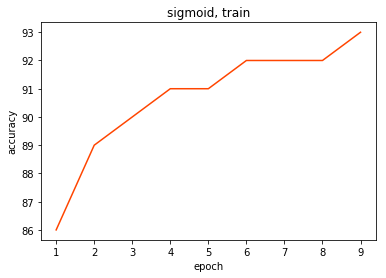

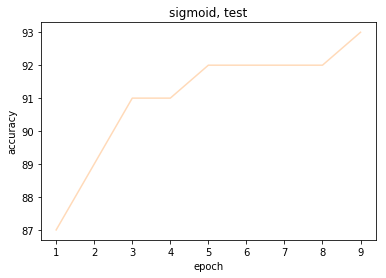

In [266]:
plot_accuracy(train_accuracy_epoch, test_accuracy_epoch, 'sigmoid')

In [272]:
class Net_LeakyReLu(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc3 = nn.Linear(16 * 4 * 4, 120)
        self.fc1 = nn.Linear(120, 600)
        self.fc2 = nn.Linear(600, 1000)
        
    def forward(self, x):
        x = x.view(-1, 1, 50, 50)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [273]:
model_LeakyReLu = Net_LeakyReLu()
optimizer = optim.SGD(model_LeakyReLu.parameters(), lr=0.01)
train_accuracy_epoch = []
test_accuracy_epoch = []

epoch_num = 10
for epoch in range(1, epoch_num):
    train(epoch, model_LeakyReLu)
    test(' ', model_LeakyReLu)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311463
Train Epoch: 1 [2000/60000 (3%)]	Loss: 1.832512
Train Epoch: 1 [4000/60000 (7%)]	Loss: 1.465184
Train Epoch: 1 [6000/60000 (10%)]	Loss: 0.492312
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.778654
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.608770
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.691420
Train Epoch: 1 [14000/60000 (23%)]	Loss: 0.539693
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.419200
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.357589
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.126219
Train Epoch: 1 [22000/60000 (37%)]	Loss: 0.115960
Train Epoch: 1 [24000/60000 (40%)]	Loss: 0.400314
Train Epoch: 1 [26000/60000 (43%)]	Loss: 0.524553
Train Epoch: 1 [28000/60000 (47%)]	Loss: 0.704216
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.250479
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.583259
Train Epoch: 1 [34000/60000 (57%)]	Loss: 0.196196
Train Epoch: 1 [36000/60000 (60%)]	Loss: 0.197735
Train Epoch: 1 [38000/60000 (63%)]	Loss: 0.187694
Train Epoch

Train Epoch: 6 [6000/60000 (10%)]	Loss: 0.038099
Train Epoch: 6 [8000/60000 (13%)]	Loss: 0.486250
Train Epoch: 6 [10000/60000 (17%)]	Loss: 0.071195
Train Epoch: 6 [12000/60000 (20%)]	Loss: 0.015503
Train Epoch: 6 [14000/60000 (23%)]	Loss: 0.007853
Train Epoch: 6 [16000/60000 (27%)]	Loss: 0.021718
Train Epoch: 6 [18000/60000 (30%)]	Loss: 0.503904
Train Epoch: 6 [20000/60000 (33%)]	Loss: 0.055849
Train Epoch: 6 [22000/60000 (37%)]	Loss: 0.569242
Train Epoch: 6 [24000/60000 (40%)]	Loss: 0.257021
Train Epoch: 6 [26000/60000 (43%)]	Loss: 0.080062
Train Epoch: 6 [28000/60000 (47%)]	Loss: 0.030644
Train Epoch: 6 [30000/60000 (50%)]	Loss: 0.050634
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.043174
Train Epoch: 6 [34000/60000 (57%)]	Loss: 0.348724
Train Epoch: 6 [36000/60000 (60%)]	Loss: 0.119093
Train Epoch: 6 [38000/60000 (63%)]	Loss: 0.427502
Train Epoch: 6 [40000/60000 (67%)]	Loss: 0.118773
Train Epoch: 6 [42000/60000 (70%)]	Loss: 0.020143
Train Epoch: 6 [44000/60000 (73%)]	Loss: 0.023584
Tr

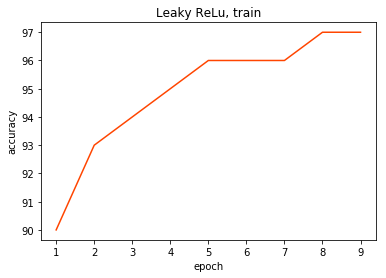

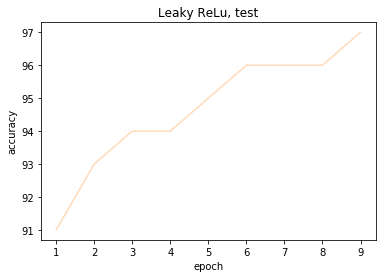

In [274]:
plot_accuracy(train_accuracy_epoch, test_accuracy_epoch, 'Leaky ReLu')

### 4. Autoencoders
An autoencoder is an network used for unsupervised learning of efficient codings. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction. Also, this technique can be used to train deep nets.

Architecturally, the simplest form of an autoencoder is a feedforward net very similar to the multilayer perceptron (MLP), but with the output layer having the same number of nodes as the input layer, and with the purpose of reconstructing its own inputs. Therefore, autoencoders are unsupervised learning models. An autoencoder always consists of two parts, the encoder and the decoder. Encoder returns latent representation of the object (compressed representation, usuallu smaller dimension), but decoder restores object from this latent representation. Autoencoders are also trained to minimise reconstruction errors (e.g. MSE).

Various techniques exist to prevent autoencoders from learning the identity and to improve their ability to capture important information:
1. Denoising autoencoder - take a partially corrupted input.
2. Sparse autoencoder - impose sparsity on the hidden units during training (whilst having a larger number of hidden units than inputs).
3. Variational autoencoder models inherit autoencoder architecture, but make strong assumptions concerning the distribution of latent variables.
4. Contractive autoencoder - add an explicit regularizer in objective function that forces the model to learn a function that is robust to slight variations of input values.

#### Exercises
1. Train 2 layers autoencoder that compressed mnist images to $\mathbb{R}^3$ space.
2. For each digit plot several samples in 3D axis (use "%matplotlib notebook" mode or plotly). How do digits group?
3. Train autoencoder with more layers. What are results?
4. Use autoencoder to pretrain 2 layers (unsupervised) and then train the following layers with supervised method.